# Breast Cancer Diagnostic with Adaline

In [4]:
import pandas as pd # for loading data csv into dataframe and cleaning data
import os # for building url path
import numpy as np 
import matplotlib.colors # will use ListedColorMap to plot results
import matplotlib.pyplot as pp

## Read cancer data from ML database

In [10]:
cancer_data_url = os.path.join ('https://archive.ics.uci.edu', 'ml', 'machine-learning-databases', 'breast-cancer-wisconsin', 'breast-cancer-wisconsin.data')
cancer_data = pd.read_csv(cancer_data_url, header=None, encoding='utf-8')
cancer_data.columns = ['id', 'thickness', 'size uniformity', # assign columns more useful names
                       'shape uniformity', 'marginal adhesion',
                       'epi cell size', 'bare nuclei', 'bland chromatin',
                       'normal nucleoi', 'mitoses', 'class']
cancer_data

,id,thickness,size uniformity,shape uniformity,marginal adhesion,epi cell size,bare nuclei,bland chromatin,normal nucleoi,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


In [6]:
def every_unique_pair(mylist):
    """returns every positionally unique pair in a given list: assumes that no elements in the list appear more than once"""
    ret_list = []
    list_copy = mylist[1:].copy()
    for i in mylist:
        for j in list_copy:
            ret_list.append([i,j])
        list_copy = list_copy[1:]
    return ret_list

# figure,subplotx = pp.subplots(len(every_unique_pair(cancer_data.columns[1:len(cancer_data.columns)-1])))
# figure.suptitle('Visual Comparison of Linear Separability')
# figure.set_size_inches(20, 40)
# for i, pair in enumerate(every_unique_pair(cancer_data.columns[1:len(cancer_data.columns) - 1])):
#     c1,c2 = pair
#     plot_classes_by_columns(subplotx[i], cancer_data, c1, c2)

## Adaline SGD Classifier Class

### As implemented in Ch02

In [22]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier."""
    def __init__(self, learning_rate=0.01, epochs=10, shuffle=True, random_seed=None):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights_initialized = False
        self.shuffle = shuffle
        self.random_seed = random_seed
        
    def fit(self, X, y):
        """"""
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.epochs):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.weights_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_seed)
        self.weights = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.weights_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.weights[1:] += self.learning_rate * xi.dot(error)
        self.weights[0] += self.learning_rate * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.weights[1:]) + self.weights[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

In [24]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):
    """Fn to plot the feature points and the linear seperator"""

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    pp.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    pp.xlim(xx1.min(), xx1.max())
    pp.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        pp.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

In [8]:
def accuracy_and_misclasses(prediction, labels):
    """Fn to determine accuracy"""
    missclassifications = 0
    correct_predictions = len(labels)
    for a,b in zip(prediction, labels):
        if a != b:
            missclassifications += 1
            correct_predictions -= 1
    return (correct_predictions / len(labels), missclassifications)

In [25]:
def split_fit_test(c1, c2, testtrain_ratio, dataframe=cancer_data, verbose=False, learning_rate=0.1, epochs=50):
    """split data from feature columns c1 and c2 into train and test sets at tt_ratio proportions and fit/test a perceptron"""
    
    # get the integer indeces corresponding to the column names passed to split_fit_test
    c1_idx = dataframe.columns.get_loc(c1)
    c2_idx = dataframe.columns.get_loc(c2)
    
    # number of rows of dataframe which will belong to the training set (we know the number in the test set from this implicitly)
    num_train = len(dataframe.index) - int(len(dataframe.index) * testtrain_ratio)
    
    # Training set
    y_train = cancer_data.iloc[:num_train,10].values # the array of target values: 2 for benign, 4 for malignant
    y_train = np.where(y_train == 2, -1, 1) # change class labels 2 and 4 to -1 and 1 respectively
    X_train = cancer_data.iloc[:num_train, [c1_idx,c2_idx]].values
    X_train_std = np.copy(X_train)
    X_train_std[:, 0] = (X_train[:, 0] - X_train[:, 0].mean()) / X_train[:, 0].std()
    X_train_std[:, 1] = (X_train[:, 1] - X_train[:, 1].mean()) / X_train[:, 1].std()
    
    # Testing set
    y_test = cancer_data.iloc[num_train:,10].values # analagous to above
    y_test = np.where(y_test == 2, -1, 1)
    X_test = cancer_data.iloc[num_train:, [c1_idx, c2_idx]].values
    
    adaSGD = AdalineSGD(learning_rate=learning_rate, epochs=epochs)
    adaSGD.fit(X_train_std, y_train)
    
    prediction = adaSGD.predict(X_test)
    accuracy,misclasses = accuracy_and_misclasses(prediction, y_test)
    if verbose:
        print("For features", c1, "and", c2, ", and test/train ratio", testtrain_ratio, "the perceptron had", misclasses, "missclassifications and had an accuracy of", accuracy, "\n")
    plot_decision_regions(X_train, y_train, adaSGD)
    return (accuracy, misclasses)

## Standardize the Training Feature Matrix

(0.22009569377990432, 163)

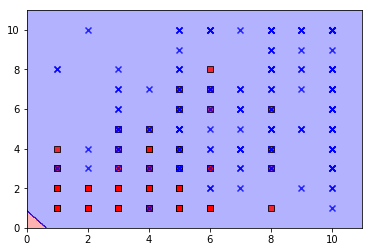

In [26]:
split_fit_test('thickness', 'shape uniformity', 0.3)